In [21]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import tellurium as te
from odbm.odbm import ModelBuilder, ModelHandler
import matplotlib.pyplot as plt
from odbm.vis import *
from odbm.utils import extractParams, fmt


In [40]:
model_species = pd.read_excel('Examples/multi_enzyme_model.xlsx', sheet_name = 'Species & Base Mechanisms', engine = 'openpyxl').dropna('index','all')
model_rxns = pd.read_excel('Examples/multi_enzyme_model.xlsx', sheet_name = 'Reaction', engine = 'openpyxl').dropna('index','all')

In [17]:
expression_limit = 0.05 
enzyme_ratio = {'Sda':1, 'PCX': 100, 'Mdh': 1}
N_ratios = sum(enzyme_ratio.values())
expression_fudge = 1/10
enzymeInit = {k:expression_limit*expression_fudge/N_ratios*v for k,v in enzyme_ratio.items()}

solubilities = {    'ATP' : 98.619,
                    'Serine': 2380.952,
                    'HCO3' : 1470.588,
                    'NADH' : 150.739 
                }
sol_fudge = 1/20
solubilities = {k:v*sol_fudge for k,v in solubilities.items()}
solubilities['Serine'] = min(solubilities.values())

for k,v in solubilities.items():
    model_species.loc[model_species['Label'] == k,'StartingConc'] = v

# constant_species = ['ATP','NADH']
# # this kind of works
# for s in constant_species:
#     model_species.loc[model_species['Label'] == s,'Label'] = '$'+s

serine_mw = 105.09
malate_mw = 134.0874

In [18]:
fluxes = {'Pyruvate': 12.478089, 'Serine': 1.678, 'Malate': 6.267} #units of mmol/gDW*hr
amounts = {'Pyruvate': 0.39, 'Serine': 0.068, 'Malate': 1.7} #units of mmol/gDW*hr

prot_dilution_factor = {'Pyruvate': 25*1000, 'Serine': 25*1000, 'Malate': 25*1000}

def convertFlux(fluxes):
    new_fluxes = {}
    for f in fluxes:
        new_fluxes[f] = (fluxes[f]*(3E-13)/(1E-15))/prot_dilution_factor[f]/3600/amounts[f]
    return new_fluxes

new_fluxes = convertFlux(fluxes)

In [53]:
modelfile = 'Examples/multi_enzyme_model.txt'
myModel = ModelBuilder(model_species, model_rxns)
myModel.saveModel(modelfile)

model = open(modelfile,'r').read()
r  = te.loada(model)

sdaV = list(map(lambda x:x.upper(),model_species[['Sda' in s for s in model_species['Label']]]['Label']))[:4]
pcxV = list(map(lambda x:x.upper(),model_species[['PCX' in s for s in model_species['Label']]]['Label']))[:4]
mdhV = list(map(lambda x:x.upper(),model_species[['Mdh' in s for s in model_species['Label']]]['Label']))[:4]

In [54]:
results_id = np.empty((len(sdaV), len(pcxV), len(mdhV)), dtype=int)
results = []
selections = list(map(fmt, myModel.species['Label'])) + list(myModel.rxns['Label']) + ['time']

count = 0
for i,sda in enumerate(sdaV):
    for j,pcx in enumerate(pcxV):
        for k,mdh in enumerate(mdhV):
            r.resetAll()
            r['k_R13'] = new_fluxes['Serine']
            r['k_R14'] = new_fluxes['Pyruvate']
            r['k_R15'] = new_fluxes['Malate']

            r['Cmax_'+sda] = enzymeInit['Sda']
            r['Cmax_'+pcx] = enzymeInit['PCX']
            r['Cmax_'+mdh] = enzymeInit['Mdh']
            results_id[i,j,k] = count
            results.append(r.simulate(0,24*60*60,1000, selections=selections))
            count += 1

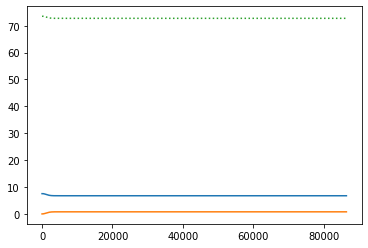

In [ ]:
df = pd.DataFrame(results[0], columns = results[0].colnames)
df.round(2)
plt.plot(df['time'],df['NADH'],  label = 'NADH')
plt.plot(df['time'],df['ADP'], label = 'ADP')
plt.plot(df['time'],df['HCO3'],  linestyle = 'dotted', label = 'CO2')

#plt.xlim(0, 100)
#plt.ylim(0,200)


[(0.0, 300.0), (0.0, 300.0), (0.0, 300.0)]

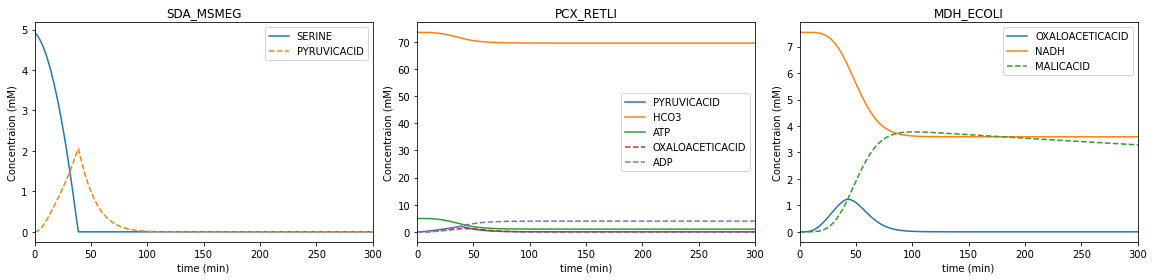

In [55]:
variants = (0,0,0) #define combination of variants to plot
v_labels = [v[k] for v,k in zip([sdaV, pcxV, mdhV], variants)] #get variant names
run = int(results_id[variants]) #return simulation run  # in which that combination was tested
rxn_idx = [int(variants[0]),int(variants[1]+4), int(variants[2]+8)] #brute force method of getting reaction index for each variant
f, ax = rxn_plot(myModel, results[run], rxn_idx, figsize=(16,4), titles = v_labels)
[a.set_xlim([0,300]) for a in ax]

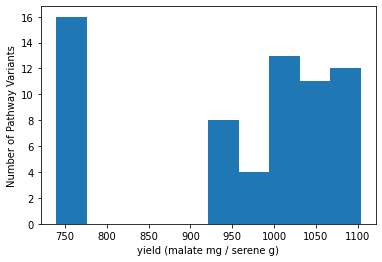

In [57]:
plt.hist([((max(r['MALICACID'])*malate_mw)/(r['SERINE'][0]*serine_mw)*1000) for r in results]);
plt.xlabel('yield (malate mg / serene g)');
plt.ylabel('Number of Pathway Variants');

(0.0, 200.0)

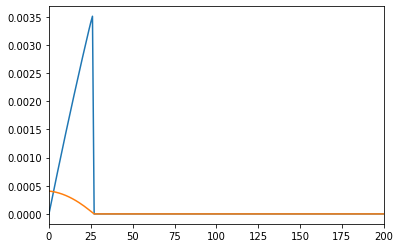

In [60]:
plt.plot(results[0]['R1'])
plt.plot(results[0]['R13'])

plt.xlim([0,200])


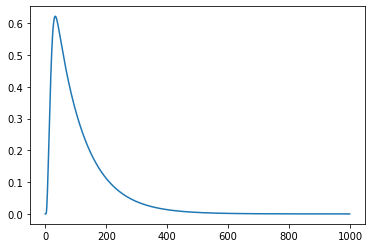

In [11]:
plt.plot(results[0]['MALICACID'])

In [49]:
norm = np.random.normal(10,3,1000)

MH = ModelHandler(model)
MH.setSimParams = True

MH.setParameterScan({'ATP':norm, 'ADP':norm})
res = MH.sensitivityAnalysis(metric = lambda x: x['[ATP]'][-1])